In [1]:
"""
Created on Tue Jul 9 16:48:32 2019

@author: Andrew Welsh

This notebook is for doing a model fit to as much historical data as possible, then evaluating that model fit on unseen data
with a 9 month gap between the latest month in the training set, and the earliest month in the eval data set.
The data must be extracted via SQL prior to inclusion in this notebook (until a data connection directly to the database 
is configured), then saved via CSV and uploaded here, which is then read here. 

The parameter tuning for this model fit is accomplished with the churn_grid_search_parameter_tuning notebook

Intended use is production model re-fitting process every 6 months, as well as the initial model fit, to provide evaluation 
metrics to the business.

Output: model fit confusion matrix
"""

import pandas as pd
import churn_common as p #imports F2 score function, model_fit function

# imported data already has nulls cleaned and unused columns dropped
# churn_cloud_model_training_fit.csv is output from 'churn_cloud_model_training_fit.py' python script
cloud_train = pd.read_csv('churn_cloud_model_training_fit.csv', encoding='ISO-8859-1')

print('Query complete')
pd.options.display.max_columns = None

Query complete


In [2]:
#index column from CSV is imported as a separate column, labeled 'Unnamed: 0', therefore must be dropped before model fit
cloud_train.drop(['Unnamed: 0'], axis=1, inplace=True)

#Model evaluation scores are determined by the "churn_grid_search_parameter_tuning" and 
#"churn_model_fit - feature selection engineering" notebooks
#therefore, we use the whole dataset for model fit.

In [3]:
#==================================================================================================================
#==================================================================================================================
# Split data by revenue segment (per business request)
#==================================================================================================================
#==================================================================================================================
#split datasets into low-med-hi revenue segments
#live model fit (entire dataset)
cloud_low, cloud_mid, cloud_hi = p.split_df_revenue_segments(cloud_train, 'average_invoiced_last_12_months', low=1000, high=10000)

print("Data split by revenue segment")

#==================================================================================================================
#==================================================================================================================
# Resample minority class in training dataset
#==================================================================================================================
#==================================================================================================================

#for repeatable results, set seed equal to an integer; for random assignment, set seed to None
seed = None

cloud_low_rus = p.AndrewsRandomUnderSampler(cloud_low, 'target', seed)
cloud_mid_rus = p.AndrewsRandomUnderSampler(cloud_mid, 'target', seed)
cloud_hi_rus = p.AndrewsRandomUnderSampler(cloud_hi, 'target', seed)

print('Minority class resampling complete')

Data split by revenue segment
Minority class resampling complete


In [4]:
#define lists of target (y) and predictor (x) columns
exclude_col = [
        'account_number'
        ,'time_month_key'
        ,'time_month_key_dt'
        ,'account_name'
        ,'average_invoiced_last_12_months'
        ,'revenue_segment'
        ,'avg_monthly_invoice_band'
        ,'churn_flag'
        ,'target'
        ,'pct_change'
        ,'first_churn_tmk'
        ,'total_invoiced_in_month'
        ,'average_invoiced_next_6_months'
        ,'num_months_last_12_months'
        ,'num_months_next_6_months'
        ,'month_order'
        ,'month_order_desc'
        ,'time_month_key_eo_last_month_dt'
        ,'account_type_cloud_uk'
        ,'account_segment'
        ,'account_sub_type'
 ]

#populate this list with list of included features determined by iterating through the feature engineering/selection notebook
include_col = ['3 mth pct change number of device_status = computer no longer active'
               ]

predictors = list(cloud_train.columns[~cloud_train.columns.isin(exclude_col)])
#predictors = list(cloud_train.columns[cloud_train.columns.isin(include_col)])

#create copy of the X and Y columns for live model fit on entire dataset
x_live_low = cloud_low_rus[predictors] #uses list of columns excluding target (predictors) to select columns for x_low
y1_live_low = cloud_low_rus['target']

x_live_mid = cloud_mid_rus[predictors]
y1_live_mid = cloud_mid_rus['target']

x_live_hi = cloud_hi_rus[predictors]
y1_live_hi = cloud_hi_rus['target']

print("Predictor and target datasets ready")

Predictor and target datasets ready


In [5]:
#import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import time
import datetime
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

/app/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)



Model Fit Start time
2019-11-21 16:21:00


acc_tenure_in_months                                 13065
total invoiced in last 6 months                      12897
total invoiced in last 6 months vs prior 6 months    12766
avg invoiced in last 6 months vs prior 6 months      12154
avg per line item invoiced in last 6 months          11469
dtype: int64

Model Fit End time
2019-11-21 16:25:52

Model Fit Start time
2019-11-21 16:25:52


pct of invoice - next gen servers                    3288
total invoiced in last 6 months                      2973
avg per line item invoiced in last 6 months          2802
acc_tenure_in_months                                 2795
total invoiced in last 6 months vs prior 6 months    2741
dtype: int64

Model Fit End time
2019-11-21 16:26:36

Model Fit Start time
2019-11-21 16:26:36


acc_tenure_in_months                                                  790
avg mthly num of invoiced items in last 6 months vs prior 6 months    756
pct of invoice - next gen ser

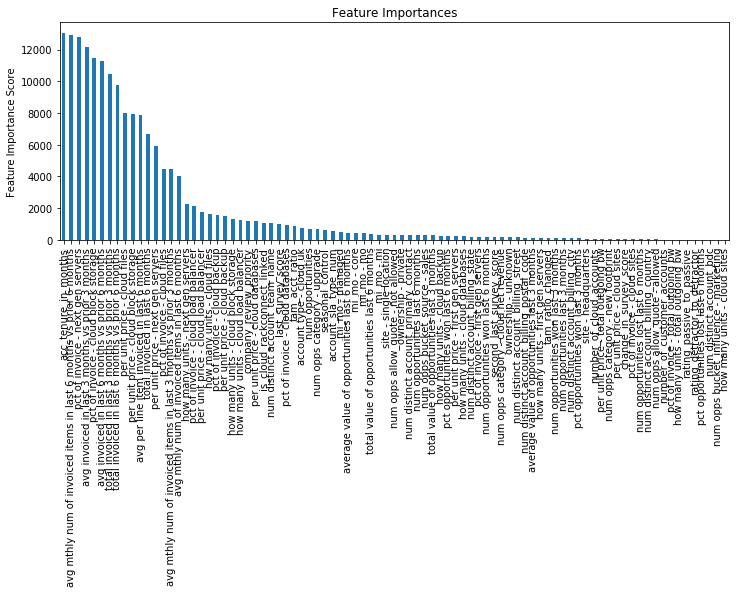

In [6]:
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================
#Model run - for live data (train on entire dataset)
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================


xgb_final_low = XGBClassifier(
        learning_rate=0.3, 
        n_estimators=1300, 
        max_depth=13, 
        max_features=13, 
        subsample=0.9,
        min_child_weight=1,
        gamma=0.1, 
        colsample_bytree=0.8, 
        scale_pos_weight=1, 
        reg_alpha=1,
        reg_lambda=0.01,
        #random_state=seed, 
        eval_metric='auc',
        objective='binary:logistic',
        nthread=128
        )

xgb_final_mid = XGBClassifier(
        learning_rate=0.2, 
        n_estimators=1300, 
        max_depth=13, 
        max_features=13, 
        subsample=0.9,
        min_child_weight=1,
        gamma=0.1, 
        colsample_bytree=0.7, 
        scale_pos_weight=1, 
        reg_alpha=0.1,
        reg_lambda=0.01,
        #random_state=seed, 
        eval_metric='auc',
        objective='binary:logistic',
        nthread=128
        )

xgb_final_hi = XGBClassifier(
        learning_rate=0.1, 
        n_estimators=1300, 
        max_depth=9, 
        max_features=13, 
        subsample=0.7,
        min_child_weight=1,
        gamma=0, 
        colsample_bytree=0.7, 
        scale_pos_weight=1, 
        reg_alpha=1,
        reg_lambda=1e-05,
        #random_state=seed, 
        eval_metric='auc',
        objective='binary:logistic',
        nthread=128
        )

p.modelfit(xgb_final_low, x_live_low, y1_live_low.values.ravel(), predictors)
p.modelfit(xgb_final_mid, x_live_mid, y1_live_mid.values.ravel(), predictors)
p.modelfit(xgb_final_hi, x_live_hi, y1_live_hi.values.ravel(), predictors)

In [7]:
import joblib

In [8]:
#save fitted model for use in production (monthly)
model_save_low = 'churn_cloud_model_fit_low.sav'
model_save_mid = 'churn_cloud_model_fit_mid.sav'
model_save_hi = 'churn_cloud_model_fit_hi.sav'
joblib.dump(xgb_final_low, model_save_low)
joblib.dump(xgb_final_mid, model_save_mid)
joblib.dump(xgb_final_hi, model_save_hi)

['churn_cloud_model_fit_hi.sav']